# Assignment 9

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:

    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots

import tensorflow as tf
from tensorflow.keras.datasets import imdb

2025-03-16 14:48:01.767451: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---
### Step 1: Data ingestion

In this lab, you'll train a <span style="color:chocolate">sentiment</span> classifier for movie reviews. 

* The input is the text of a movie review;
* The output is the probability the input is a positive review.
* The target labels are binary, 0 for negative and 1 for positive.

The data includes 50,000 movie reviews on IMDB. The data comes pre-segmented into train and test splits. The [data loading function](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data) below also splits each input text into tokens (words), and maps the words to integer values. Each input is a sequence of integers corresponding to the words.

In [2]:
# read data
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

X_train.shape: (25000,)
Y_train.shape: (25000,)
X_test.shape: (25000,)
Y_test.shape: (25000,)


---
### Step 2: Data preprocessing

Let's have a look at the first training example:

In [3]:
print('First training example data:', X_train[0])
print('First training example label:', Y_train[0])

First training example data: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
First t

As you can see, the first training example is a positive review. However, that sequence of integer IDs is hard to read. 

The data loader provides a dictionary mapping words to IDs. Let's create a reverse index.


In [4]:
# The imdb dataset comes with an index mapping words to integers.
# In the index the words are ordered by frequency they occur.
index = imdb.get_word_index()

# Because we used index_from=3 (above), setting aside ids below 3 for special
# symbols, we need to add 3 to the index values.
index = dict([(key, value+3) for (key, value) in index.items()])

# Create a reverse index so we can lookup tokens assigned to each id.
reverse_index = dict([(value, key) for (key, value) in index.items()])
reverse_index[1] = '<START>'  # start of input
reverse_index[2] = '#'        # out-of-vocabulary (OOV)
reverse_index[3] = '<UNUSED>'

max_id = max(reverse_index.keys())
print('Largest ID:', max_id)

Largest ID: 88587


Note that our index (and reverse index) have <span style="color:chocolate">88,587</span> tokens. That's quite <span style="color:chocolate">a large vocabulary</span>! 

Next, let's write a decoding function for our data.

In [5]:
def decode(token_ids):
  """Return a string with the decoded text given a list of token ids."""
  # Try looking up each id in the index, but return '#' (for OOV) if not found.
  tokens = [reverse_index.get(i, "#") for i in token_ids]

  # Connect the string tokens with a space.
  return ' '.join(tokens)

# Show the ids corresponding tokens in the first example.
print(X_train[0])
print(decode(X_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
<START> this film was just brilliant

---
### Step 3: Exploratory Data Analysis (EDA)

### <span style="color:chocolate">Exercise 1:</span> Text lengths (10 points)

Using the training reviews data, answer the following questions:

1. What are the minimum, maximum, and mean lengths of positive and negative reviews?
2. Create a histogram to visualize the distribution of positive and negative review lengths. Make sure to provide a descriptive title and axis labels.

Positive Reviews:
  Min length: 13
  Max length: 2494
  Mean length: 241.56

Negative Reviews:
  Min length: 11
  Max length: 1571
  Mean length: 235.86



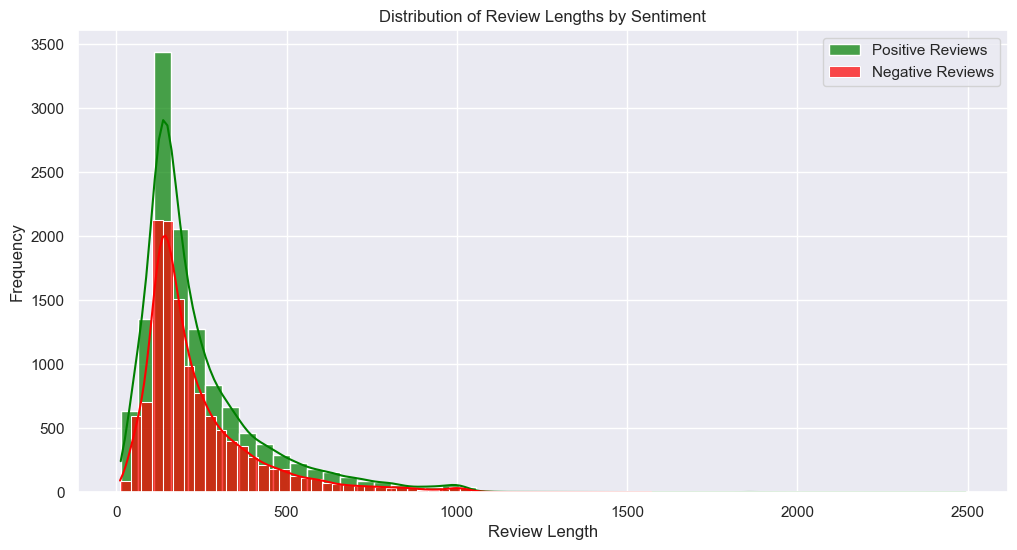

In [6]:
# YOUR CODE HERE
# Separate positive and negative reviews
positive_reviews = [len(X_train[i]) for i in range(len(X_train)) if Y_train[i] == 1]
negative_reviews = [len(X_train[i]) for i in range(len(X_train)) if Y_train[i] == 0]

# Calculate statistics
def review_stats(label, lengths):
    print(f"{label} Reviews:")
    print(f"  Min length: {np.min(lengths)}")
    print(f"  Max length: {np.max(lengths)}")
    print(f"  Mean length: {np.mean(lengths):.2f}\n")

review_stats("Positive", positive_reviews)
review_stats("Negative", negative_reviews)

# Plot histograms
plt.figure(figsize=(12, 6))

sns.histplot(positive_reviews, bins=50, kde=True, color='green', label='Positive Reviews', alpha=0.7)
sns.histplot(negative_reviews, bins=50, kde=True, color='red', label='Negative Reviews', alpha=0.7)

plt.title("Distribution of Review Lengths by Sentiment")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### <span style="color:chocolate">Exercise 2:</span> Token counts (10 points)

Using the training data, create a table listing the counts of positive and negative examples that contain each token provided below.

Positive Reviews:
  Min length: 13
  Max length: 2494
  Mean length: 241.56

Negative Reviews:
  Min length: 11
  Max length: 1571
  Mean length: 235.86



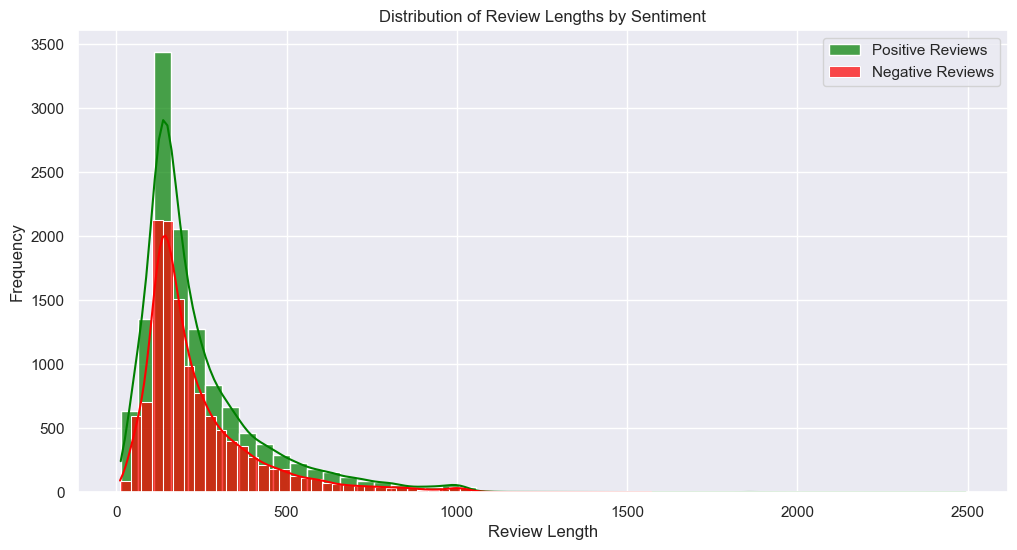


Token Counts in Positive and Negative Reviews:
Token      Positive   Negative  
good       4767       4849      
bad        1491       4396      
amazing    868        240       
boring     301        1205      
laugh      525        685       
cry        231        114       


In [7]:
tokens = ['good', 'bad', 'amazing', 'boring', 'laugh', 'cry']
# YOUR CODE HERE
# Separate positive and negative reviews
positive_reviews = [len(X_train[i]) for i in range(len(X_train)) if Y_train[i] == 1]
negative_reviews = [len(X_train[i]) for i in range(len(X_train)) if Y_train[i] == 0]

# Calculate statistics
def review_stats(label, lengths):
    print(f"{label} Reviews:")
    print(f"  Min length: {np.min(lengths)}")
    print(f"  Max length: {np.max(lengths)}")
    print(f"  Mean length: {np.mean(lengths):.2f}\n")

review_stats("Positive", positive_reviews)
review_stats("Negative", negative_reviews)

# Plot histograms
plt.figure(figsize=(12, 6))

sns.histplot(positive_reviews, bins=50, kde=True, color='green', label='Positive Reviews', alpha=0.7)
sns.histplot(negative_reviews, bins=50, kde=True, color='red', label='Negative Reviews', alpha=0.7)

plt.title("Distribution of Review Lengths by Sentiment")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Count occurrences of specific tokens in positive and negative reviews
tokens = ['good', 'bad', 'amazing', 'boring', 'laugh', 'cry']

# Create a table to store counts
counts = {token: {'positive': 0, 'negative': 0} for token in tokens}

# Iterate through training data and count token occurrences
for i, review in enumerate(X_train):
    sentiment = 'positive' if Y_train[i] == 1 else 'negative'
    for token in tokens:
        token_id = index.get(token)
        if token_id in review:
            counts[token][sentiment] += 1

# Display the table
print("\nToken Counts in Positive and Negative Reviews:")
print(f"{'Token':<10} {'Positive':<10} {'Negative':<10}")
for token, count in counts.items():
    print(f"{token:<10} {count['positive']:<10} {count['negative']:<10}")

---
### Step 4: Data preprocessing (cont'd)

As is clear from the review length histogram, the current representation of the review text is a variable-length array. Since fixed-length arrays are easier to work with in Tensorflow, you will add special padding tokens at the end of each review until they are all the same length. You will also truncate all training inputs to a specified length.

### <span style="color:chocolate">Exercise 3:</span> Reduced length and padding (10 points)

Fill in the <span style="color:green">NotImplemented</span> parts of the <span style="color:chocolate">truncate_pad_data()</span> function below by following these instructions:

1. Restrict the maximum number of tokens by truncating all reviews to a length of 300;
2. Append special padding tokens (value = 0) to the end of each review until all reviews are of the same length.

In [8]:
def truncate_pad_data(sequences, max_length):
    # Keras has a convenient utility for padding a sequence:
    # tf.keras.preprocessing.sequence.pad_sequences()
    # Also make sure you get a numpy array rather than an array of lists.
    padded_data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post', value=0)
    return padded_data

# 1+ 2: Truncate and pad the training data
X_train_padded = truncate_pad_data(X_train, max_length=300)

# Check the padded output.
print('Length of X_train[0]:', len(X_train[0]))
print('Length of X_train_padded[0]:', len(X_train_padded[0]))
print(X_train_padded[0])

Length of X_train[0]: 218
Length of X_train_padded[0]: 300
[    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670 22665     9    35   480   284     5   150     4   172   112
   167 21631   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18 19193     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4 31050     7  3766
     5   723    36    71    43   530   476    26   400   317    4

Next, you want to be able to limit the vocabulary size. Since the <span style="color:chocolate">truncate_pad_data()</span> function produces fixed-length sequences in a numpy matrix, one can use clever numpy indexing to efficiently replace all token ids larger than some value with the designated out-of-vocabulary (OOV) id.

### <span style="color:chocolate">Exercise 4:</span> Reduced vocabulary (10 points)

Fill in the <span style="color:green">NotImplemented</span> parts of the <span style="color:chocolate">limit_vocab()</span> function below by following these instructions:

1. Keep just token ids less than 1000, replacing all others with OOV.

In [9]:
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  # YOUR CODE HERE
  reduced_sequences = np.where(sequences >= max_token_id, oov_id, sequences)
  return reduced_sequences

# Reduce vocabulary to 1000 tokens.
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
print(X_train_reduced[0])

# Decode to see what this looks like in tokens. Note the '#' for OOVs.
print(decode(X_train_reduced[0]))

[  1  14  22  16  43 530 973   2   2  65 458   2  66   2   4 173  36 256
   5  25 100  43 838 112  50 670   2   9  35 480 284   5 150   4 172 112
 167   2 336 385  39   4 172   2   2  17 546  38  13 447   4 192  50  16
   6 147   2  19  14  22   4   2   2 469   4  22  71  87  12  16  43 530
  38  76  15  13   2   4  22  17 515  17  12  16 626  18   2   5  62 386
  12   8 316   8 106   5   4   2   2  16 480  66   2  33   4 130  12  16
  38 619   5  25 124  51  36 135  48  25   2  33   6  22  12 215  28  77
  52   5  14 407  16  82   2   8   4 107 117   2  15 256   4   2   7   2
   5 723  36  71  43 530 476  26 400 317  46   7   4   2   2  13 104  88
   4 381  15 297  98  32   2  56  26 141   6 194   2  18   4 226  22  21
 134 476  26 480   5 144  30   2  18  51  36  28 224  92  25 104   4 226
  65  16  38   2  88  12  16 283   5  16   2 113 103  32  15  16   2  19
 178  32   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

### <span style="color:chocolate">Exercise 5:</span> One-hot encoding (0 points)

The current feature representations are **sparse**. That is, one only keeps track of the token ids that are present in the input. A **one-hot** encoding replaces a value like 22 (corresponding to 'film') with an array with a single 1 at position 22 and zeros everywhere else. This will be very memory-inefficient, but we'll do it anyway for clarity.

To avoid any memory limitations, let's dramatically reduce both the number of token positions (review length) and the number of token ids (vocabulary). 

The code below clips each review after 20 tokens and keeps only the first 1000 tokens.

In [10]:
# Keras has a util to create one-hot encodings.
X_train_padded = truncate_pad_data(X_train, max_length=20)
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
X_train_one_hot = tf.keras.utils.to_categorical(X_train_reduced)
print('X_train_one_hot shape:', X_train_one_hot.shape)

X_train_one_hot shape: (25000, 20, 1000)


Note the shape of the one-hot encoded features. For each of the 25000 training examples, you have a 20 x 1000 matrix. That is, for each of 20 token positions, you have a vector of 1000 elements containing a single 1 and 999 zeros.

You can think of these 1000-dimensional one-hot arrays as **embeddings**. Each token in the input has a 1000-dimensional representation. But because of the one-hot setup, the distance between each pair of tokens is the same ([1,0,0,...], [0,1,0,...], etc.). By contrast, learned embeddings result in meaningful distances between pairs of tokens. You'll get to that soon.

---
### Step 5: Modeling

### <span style="color:chocolate">Baseline model:</span> Logistic regression with one-hot encodings

You will start with something familiar -- logistic regression. Since your feature representation is in 2 dimensions (20 x 1000), you need to flatten it to pass it to Keras (remember you did this with the pixel data too). Try two strategies for flattening.

1. Flatten by *concatenating* (as you did with pixels), turning (20 x 1000) data into (20000,) data. The result is a separate feature for each token at each position;
2. Flatten by *averaging* over token positions, turning (20 x 1000) data into (1000,) data. The result is an array with average token counts, ignoring position.

In [11]:
def build_onehot_model(average_over_positions=False):
  """Build a tf.keras model for one-hot data."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
    
  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
      
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation="sigmoid"         # sigmoid activation for binary classification
  ))

  model.compile(loss='binary_crossentropy',   # this is a classification task
                optimizer='adam',             # fancy optimizer
                metrics=['accuracy'])

  return model

Now let's try fitting the model to your training data and check performance metrics on the validation data. But first, here's a function for plotting the learning curves given the training history object we get from Keras.

In [12]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.ylim(0,1)
  plt.legend()
  plt.show()

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5508 - loss: 0.6878 - val_accuracy: 0.6104 - val_loss: 0.6745
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6904 - loss: 0.6517 - val_accuracy: 0.6188 - val_loss: 0.6625
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7272 - loss: 0.6229 - val_accuracy: 0.6248 - val_loss: 0.6539
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7451 - loss: 0.5988 - val_accuracy: 0.6300 - val_loss: 0.6474
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7623 - loss: 0.5780 - val_accuracy: 0.6320 - val_loss: 0.6424


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        20,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,005 (234.40 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,004 (156.27 KB)

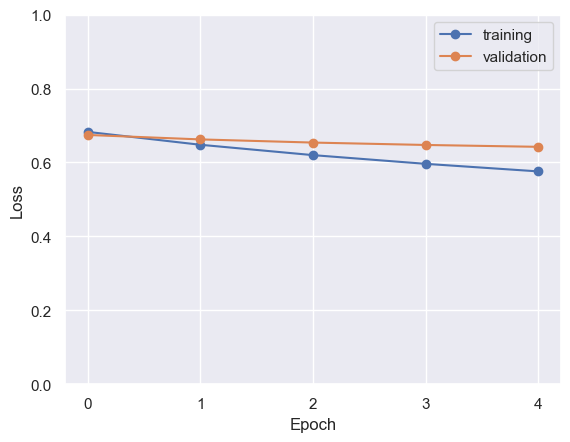

In [13]:
model1 = build_onehot_model()

# Fit the model.
history1 = model1.fit(
  x = X_train_one_hot,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model1.summary()
# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history1 = pd.DataFrame(history1.history)
plot_history(history1)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5363 - loss: 0.6927 - val_accuracy: 0.5924 - val_loss: 0.6902
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6180 - loss: 0.6889 - val_accuracy: 0.6092 - val_loss: 0.6869
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6299 - loss: 0.6854 - val_accuracy: 0.6164 - val_loss: 0.6838
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6358 - loss: 0.6821 - val_accuracy: 0.6184 - val_loss: 0.6808
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6386 - loss: 0.6791 - val_accuracy: 0.6240 - val_loss: 0.6781


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling1d        │ (None, 1000)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,005 (11.74 KB)

 Trainable params: 1,001 (3.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,004 (7.83 KB)

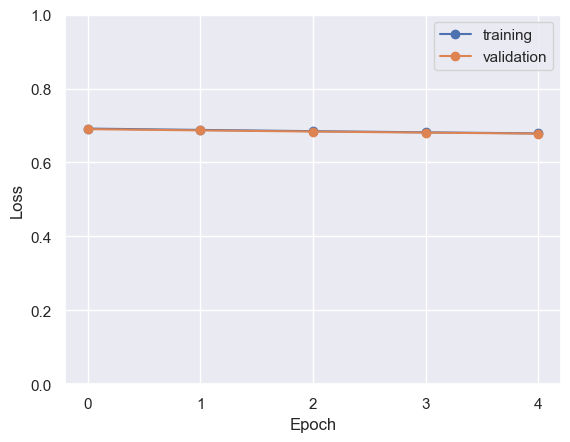

In [14]:
model_avg = build_onehot_model(average_over_positions=True)

# Fit the model.
history_avg = model_avg.fit(
  x = X_train_one_hot,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model_avg.summary()
# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history_avg = pd.DataFrame(history_avg.history)
plot_history(history_avg)

### <span style="color:chocolate">Exercise 6:</span>  Comparing logistic regression models (20 points)

Train the one-hot model using both the concatenating and the averaging strategies and compare the results. Let's call these *LR-C* (Logistic Regression Concatenating) and *LR-A* (Logistic Regression Averaging). Then answer the following questions:

1. What are the final training and validation accuracies for LR-C and LR-A?
2. How many parameters are there in each model?
3. Would you say that either model is overfitting? Why or why not?
4. Briefly describe how LR-C differs from LR-A. How do you explain the relationship between their respective validation accuracy results? 

*Written answer:*

1. <b>Final Training and Validation Accuracies </b>

Model with Concatenation (Flatten) - LR-C:

        Final Training Accuracy: 76.23%

        Final Validation Accuracy: 63.20%

Model with Averaging (Global Average Pooling) - LR-A:

        Final Training Accuracy: 63.86%

        Final Validation Accuracy: 62.40%

2. <b>Number of Parameters in Each Model</b>

LR-C (Concatenating/Flatten):

    Total Parameters: 60,005

    Trainable Parameters: 20,001

    Non-Trainable Parameters: 0

    Optimizer Parameters: 40,004

LR-A (Averaging/Global Average Pooling):

    Total Parameters: 3,005

    Trainable Parameters: 1,001

    Non-Trainable Parameters: 0

    Optimizer Parameters: 2,004

3. <b>analysis of both models: </b>

LR-C (Concatenating/Flatten):
This model achieves higher training accuracy (76.23%) compared to validation accuracy (63.20%). 
The gap between training and validation accuracy suggests that this model might be overfitting, i.e., it performs well on the training data but doesn't generalizes well on the validation data.

LR-A (Averaging/Global Average Pooling):
Model has less parameter i.e. 3,005 and is less prone to overfitting. The gap between  training accuracy (63.86%) and validation accuracy (62.40%) is smaller suggesting this generalized better than LR-C model.

4. 
LR-C model flattens the one- hot encoded input and treat's token position independently which makes the model parameter larger and is prone to overfitting vs LR-A averages the token embedding across the sequence positions. 
This reduces the number of feature and helps generalize the model better as indicated by small gaps between training and validation accuracy gap.


### <span style="color:chocolate">Improvement over baseline:</span> Logistic regression with embeddings

Next, you will train a model that replaces one-hot representations of each token with learned embeddings.

The code below uses a Keras Embedding layer, which expects to receive a sparse (rather than one-hot) representation. That is, it expects a (padded) sequence of token ids; for each id, it looks up the corresponding embedding vector.

In [15]:
def build_embeddings_model(average_over_positions=False,
                           vocab_size=1000,
                           sequence_length=20,
                           embedding_dim=2):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
      
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))

  model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])

  return model

You will train this model, this time using the averaging strategy instead of the concatenating strategy for handling the token sequence. You'll look up the embedding vectors for each token and average them to produce a single vector. Then, you'll use this averaged vector to train a logistic regression model to predict the binary label.

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5553 - loss: 0.6913 - val_accuracy: 0.6036 - val_loss: 0.6835
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6186 - loss: 0.6793 - val_accuracy: 0.6208 - val_loss: 0.6686
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6424 - loss: 0.6630 - val_accuracy: 0.6332 - val_loss: 0.6528
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6587 - loss: 0.6461 - val_accuracy: 0.6460 - val_loss: 0.6386
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6665 - loss: 0.6307 - val_accuracy: 0.6536 - val_loss: 0.6266


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 2)          │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 2)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,011 (23.48 KB)

 Trainable params: 2,003 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,008 (15.66 KB)

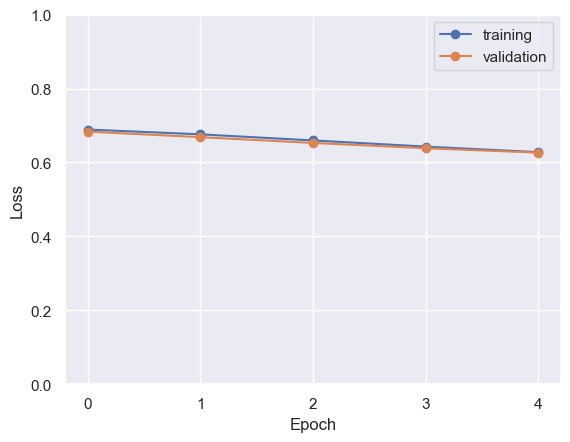

In [16]:
model2 = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=20,
                               embedding_dim=2)
history2 = model2.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model2.summary()

history2 = pd.DataFrame(history2.history)
plot_history(history2)

### <span style="color:chocolate">Exercise 7:</span> Embedding size tuning (20 points)

Experiment with embedding sizes {2, 4, 8, 16, 32, 64}, while keeping other settings fixed and using the averaging strategy instead of the concatenating strategy. Then:

1. Construct a table showing the training and validation accuracies for each model after 5 training epochs;
2. Calculate the number of parameters in each model;
3. Analyze whether learned embeddings improve performance compared to one-hot encoding, and explain why this might be the case.

In [ ]:
embedding_sizes = [2, 4, 8, 16, 32, 64]
results = []

for emb_size in embedding_sizes:
    print(f"Training model with embedding size: {emb_size}")
    
    
    model = build_embeddings_model(average_over_positions=True,
                                   vocab_size=1000,
                                   sequence_length=20,
                                   embedding_dim=emb_size)
    
    history = model.fit(
        x = X_train_reduced,  # sparse padded training data
        y = Y_train,          # corresponding binary labels
        epochs=5,             # number of epochs
        batch_size=64,        # mini-batch size
        validation_split=0.1, # use 10% of the data for validation
        verbose=1             # display progress
    )
    
    # Store the results: final training and validation accuracy
    train_accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    
    # Calculate the number of parameters in the model
    num_params = model.count_params()
    
    # Store the results
    results.append({
        'Embedding Size': emb_size,
        'Train Accuracy': train_accuracy,
        'Validation Accuracy': val_accuracy,
        'Num Parameters': num_params
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


Training model with embedding size: 2
Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5461 - loss: 0.6905 - val_accuracy: 0.6028 - val_loss: 0.6804
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6248 - loss: 0.6758 - val_accuracy: 0.6240 - val_loss: 0.6645
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6464 - loss: 0.6586 - val_accuracy: 0.6408 - val_loss: 0.6488
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6630 - loss: 0.6417 - val_accuracy: 0.6492 - val_loss: 0.6350
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6720 - loss: 0.6267 - val_accuracy: 0.6556 - val_loss: 0.6234
Training model with embedding size: 4
Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5585 - loss: 0.6907 - val_accuracy: 0.6104 - val_loss: 0.6793
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6314 - loss: 0.6726 - val_accuracy: 0.6292 - val_loss: 0.6568
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6520 - loss: 0.648

*Written answer:*

1. 

    Embedding Size      Train Accuracy      Validation Accuracy     Num Parameters

               2        0.671067               0.6556            2003

               4        0.679600               0.6640            4005

               8        0.691378               0.6760            8009

              16        0.699733               0.6876           16017

              32        0.703244               0.6892           32033

              64        0.702489               0.6928           64065


2. 
As indicated above in the table - the number of parameters increases with the embedding size.

3. 
 Learned embedding performs better than hot encoding as it capture complex patterns in the data more effectively.
 As shown above - as the embedding size increases, the model has more capture complex relationships between tokens amd the accuracy improves.


---

### Inspecting Learned Embeddings
You will now retrieve the learned embedding parameters from the trained model2 and plot the token embeddings.

The model layers in a Keras Sequential model are stored as a list and the embeddings are the first layer. You can use the <span style="color:chocolate">get_weights()</span> function to get a numpy array with the parameters.

In [21]:
# Display the model layers.
display(model2.layers)

# Retrieve the embeddings layer, which itself is wrapped in a list.
embeddings2 = model2.layers[0].get_weights()[0]
display(embeddings2.shape)

[<Embedding name=embedding, built=True>,
 <GlobalAveragePooling1D name=global_average_pooling1d, built=True>,
 <Dense name=dense, built=True>]

(1000, 2)

Now you'll use a fancy plotting tool called *plotly* to show the embeddings with hovertext so you can move your mouse over the points to see the corresponding tokens.

In [22]:
def plot_2d_embeddings(embeddings, id_start=1, count=100):
  # Get 1st and 2nd embedding dims for the desired tokens.
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]
  
  # Get the corresponding words from the reverse index (for labeling).
  tokens = [reverse_index[i] for i in range(id_start, id_start+count)]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=tokens,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest'))
  fig.show()

# Very frequent tokens tend to be more syntactic than semantic, so let's plot
# some rarer words.    
plot_2d_embeddings(embeddings2, id_start=500, count=500)

### <span style="color:chocolate">Exercise 8:</span> Interpreting embeddings (20 points)

Notice that the 2-D embeddings fall in a narrow diagonal band. Answer the following questions:

1. Have the learned embeddings separated positive and negative words? What is the most negative word? Does this make sense?
2. Give 2 examples of words that seem to have surprising embedding values and try to explain their positions. For example, what's going on with the tokens '7', '8', and '9'? What are two other surprising results?
3. The embedding for 'crazy' is very close to (0,0). Explain what this means in terms of the model's output.
4. Can you explain what you think the 2 learned embedding dimensions mean, if anything?

YOUR ANSWER HERE

1. Yes the model has seperated positive and negative words and has learned to differentiate it. The most negative word is on left lower side e.g. horrible and positive word is on right upper side : i.e. enjoyed and it does look correct for negative and positive ratings.

2. In the model with textual embeddings - digits might not carry strong semantic meaning compared to words, so they could be placed somewhere in the middle or at an unexpected location. e.g. 7 and 8 is placed 0-0.5 and 0 to 0.5 (middle).
Other two surprising results:
similarly word like "re" and "de" are placed in middle and has no direct impact to rating sentiment and are neutral/ambigious in nature.

3. crazy is very close to (0,0) suggests - its neutralitly and doesn't strongly relate to other words and doesn't form a cluster which suggests ambiguity.

4. Dimension 1 suggests the over all sentiment i.e. left most side ~-1 suggests strong negative sentiment while the right side ~1 suggests strong positive sentiment.
Dimension 2 suggests categorization and relationship of words. The similar words are clustered together on this axis. 



----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

More data and bigger models

Remember how you limited your input sequences to 20 tokens and 1000 vocabulary entries? Let's see how well you can do using more data and bigger models (more parameters).

Using pieces of code from above, set up and train a model to achieve at least 80% accuracy on both training and validation data. Ensure the following elements are included:

1. Truncate and pad input to the desired length;
2. Limit the vocabulary to the desired size;
3. Set up a model using embeddings;
4. Use the averaging strategy rather than the concatenating strategy;
5. Add additional layer(s) after the GlobalAveragePooling1D layer and before the output layer;
6. Evaluate the model's performance on the test data and comment on its generalization performance. Hint: remember to apply the same preprocessing to the test data. Use the <span style="color:chocolate">model.evaluate()</span> function for the final evaluation.

In [19]:
# YOUR CODE HERE